In [2]:
'''
brew install libomp (for OSX)
pip install torchtext -U
'''
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

pytorch 1.1.0
torchvision 0.3.0


In [3]:
IMG_SIZE = 480

COLORS = np.array([
    (0, 0, 0),       # 0=background
    (128, 0, 0),     # 1=aeroplane
    (0, 128, 0),     # 2=bicycle
    (128, 128, 0),   # 3=bird
    (0, 0, 128),     # 4=boat
    (128, 0, 128),   # 5=bottle
    (0, 128, 128),   # 6=bus
    (128, 128, 128), # 7=car
    (255, 255, 255), # 8=cat
    (192, 0, 0),     # 9=chair
    (64, 128, 0),    # 10=cow
    (192, 128, 0),   # 11=dining table
    (64, 0, 128),    # 12=dog
    (192, 0, 128),   # 13=horse
    (64, 128, 128),  # 14=motorbike
    (192, 128, 128), # 15=person
    (0, 64, 0),      # 16=potted plant
    (128, 64, 0),    # 17=sheep
    (0, 192, 0),     # 18=sofa
    (128, 192, 0),   # 19=train
    (0, 64, 128)     # 20=tv/monitor
])

# Download Model

In [4]:
deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /Users/brad/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:15<00:00, 11469093.37it/s]
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/brad/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 244545539/244545539 [00:21<00:00, 11578206.77it/s]


# Load Image

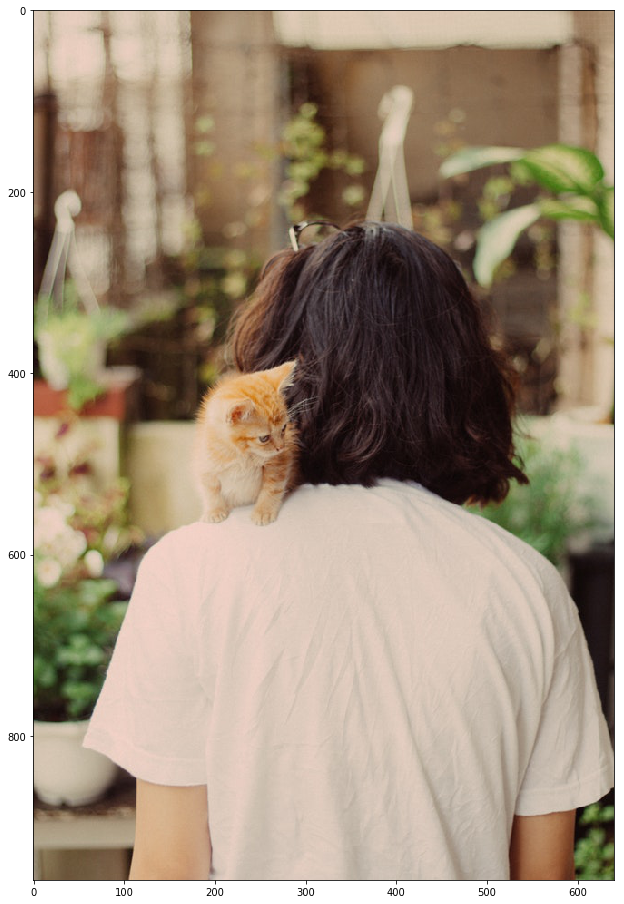

In [5]:
img = Image.open('imgs/03.jpg')

plt.figure(figsize=(16, 16))
plt.imshow(img)

# Image to Tensor

- T.Resize(256) : Resizes the image to size width 256
- T.CenterCrop(224) : Center Crops the image to have a resulting size of 224 x 224
- T.ToTensor() : Converts the image to type torch.Tensor and have values between [0, 1]
- T.Normalize(mean, std) : Normalizes the image with the given mean and standard deviation.

In [6]:
trf = T.Compose([
    T.Resize(IMG_SIZE),
#     T.CenterCrop(IMG_SIZE), # make square image
    T.ToTensor(), 
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

input_img = trf(img).unsqueeze(0)

# Inference

- [1, 21, 256, 256]
- 1: batch_size
- 21: classes
- 256, 256: image size

In [7]:
out = deeplab(input_img)['out']

print(out.shape)

torch.Size([1, 21, 719, 480])


# Extract Class Map

In [8]:
out = torch.argmax(out.squeeze(), dim=0)
out = out.detach().cpu().numpy()

print(out.shape)
print(np.unique(out))

(719, 480)
[ 0  8 15 16]


# Class Map to Segmentation Map

In [9]:
def seg_map(img, n_classes=21):
    rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for c in range(n_classes):
        idx = img == c

        rgb[idx] = COLORS[c]

    return rgb

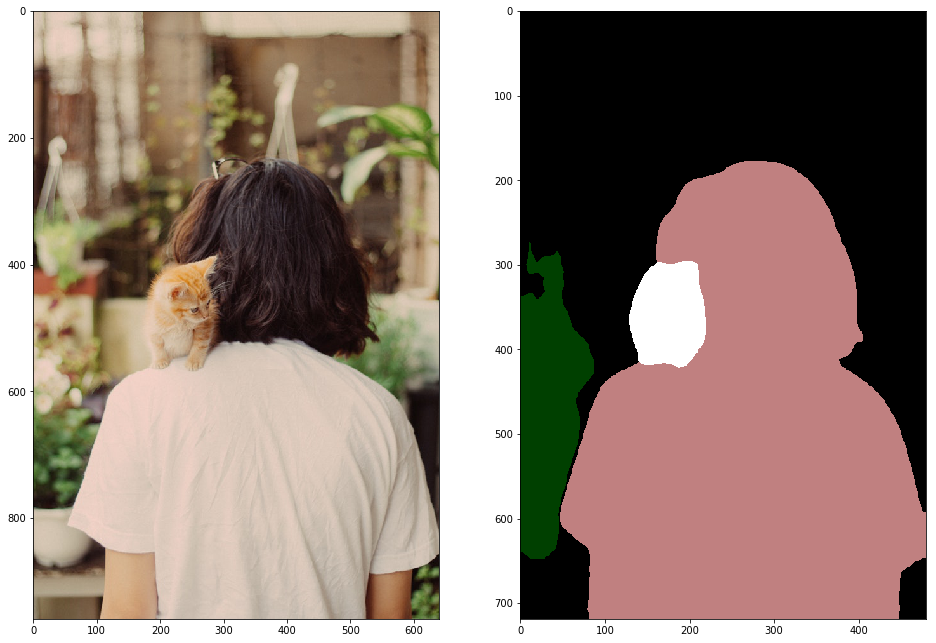

In [10]:
out_seg = seg_map(out)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
ax[0].imshow(img)
ax[1].imshow(out_seg)